[Reference](https://towardsdatascience.com/bayesian-linear-regression-a-complete-beginners-guide-3a49bb252fdc)

In [13]:
!pip install pystan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 MB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 851.1 kB/s eta 0:00:00


# Generate Data

In [14]:
import stan
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import arviz as az
import nest_asyncio
nest_asyncio.apply()

In [7]:
# Model Parameters
alpha = 4.0  # intercept
beta = 0.5 # slope
sigma = 1.0 # error-scale

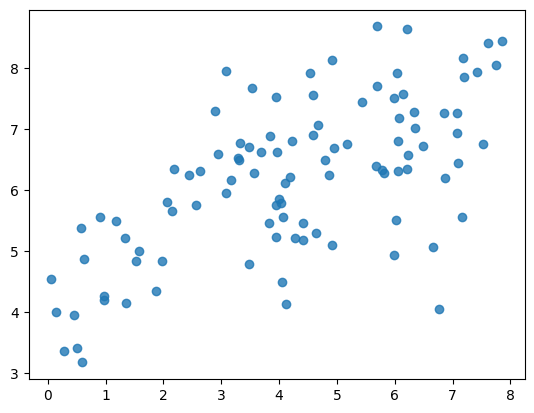

In [8]:
# Generate fake data
x =  8 * np.random.rand(100)
y = alpha + beta * x
y = np.random.normal(y, scale=sigma) # noise
# Visualize generated data
plt.scatter(x, y, alpha = 0.8)

# Build STAN model block

In [15]:
model = """
data {                    //input the data to STAN
    int N;
    vector[N] x;
    vector[N] y;
}

parameters {              //define parameters for the model
    real alpha;
    real beta;
    real sigma;
}

model {                   //define the model structure, and priors

    //priors
    alpha ~ normal(0,10);
    beta ~ normal(0,1);   //why?

    //model
    y ~ normal(alpha + beta * x, sigma);
}

generated quantities {    //get quantities of interest from fitted model
    vector[N] yhat;
    vector[N] log_lik;
    for (n in 1:N){
        yhat[n] = normal_rng(alpha + x[n] * beta, sigma);             //generate samples from model
        log_lik[n] = normal_lpdf( y[n] | alpha + x[n] * beta, sigma); //probability of data given the model and parameters
        }
}
"""

# Model Parameters

In [16]:
#STAN takes data as a dict
data = {'N': len(x), 'x': x, 'y': y}

# parameters for STAN fitting
chains = 2
samples = 1000
warmup = 10
# set seed


# Compile the model
posterior = stan.build(model, data=data, random_seed = 42)

# Train the model and generate samples
fit = posterior.sample(num_chains=chains, num_samples=samples)

Building...



Building: 58.1s, done.Messages from stanc:
Warning in '/tmp/httpstan_2bignw9v/model_tjz6b2mf.stan', line 21, column 33: A
    normal distribution is given parameter sigma as a scale parameter
    (argument 2), but sigma was not constrained to be strictly positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:  50% (2000/4000)
Sampling: 100% (4000/4000)
Sampling: 100% (4000/4000), done.
Messages received during sampling:
  Gradient evaluation took 7.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.71 seconds.
  Adjust your expectations accordingly!
warn:Rejecting initial value:
warn:  Error evaluating the log probability at the initial value.
warn:Exception: normal_lpdf: Scale parameter is -1.05429, but must be positive! (in '/tmp/httpstan_1c9tlo9b/model_tjz6b2mf.stan', line 21, column 4 to column 40)
warn:Rejecting initial value:
warn:  Error evaluating the log p

In [17]:
# Extracting traces

alpha = fit['alpha'].reshape(chains,samples) #arviz format
beta = fit['beta'].reshape(chains,samples)
sigma = fit['sigma'].reshape(chains,samples)

lp = fit['lp__'].reshape(chains,samples)

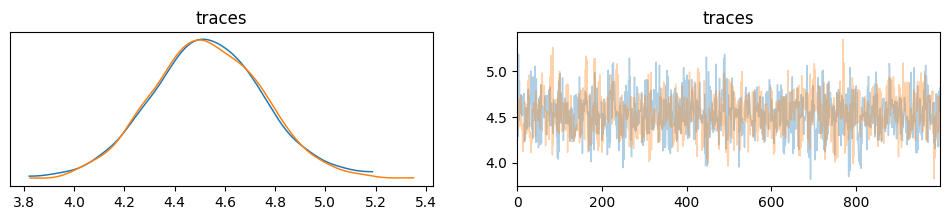

In [18]:
varname = alpha
axes = az.plot_trace(varname, compact=False)
for ax in axes.flatten():
    ax.set_title('traces')

<Axes: title={'center': 'x'}>

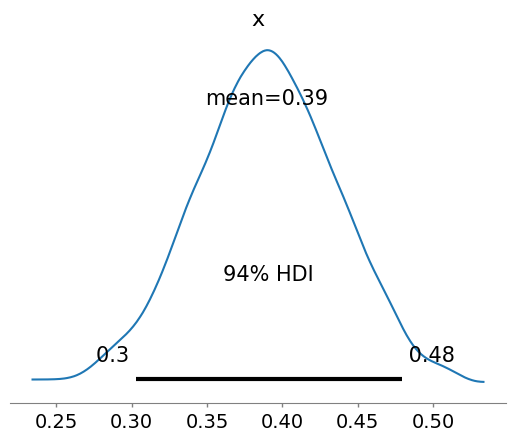

In [19]:
az.plot_posterior(beta)